In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import os

In [2]:
# Burgers' 1D;    u_t = -u * u_x + eta * u_xx
def dydt(_, u, dx, visc):
    ux = np.gradient(np.row_stack([u, u, u]).flatten(), dx)
    ux = ux[len(u) : (2 * len(u))]
    uxx = np.gradient(np.row_stack([ux, ux, ux]).flatten(), dx)
    uxx = uxx[len(u) : (2 * len(u))]
    dudt = -u * ux + visc * uxx
    return dudt

def generate_initial(
    n_points, space_resolution, n_coeffs, coeff_mean, coeff_scale, random_state
):
    rng = np.random.default_rng(random_state)
    coeffs = rng.normal(loc=coeff_mean, scale=coeff_scale, size=(n_points, n_coeffs, 2))
    coeffs = coeffs[..., 0] + 1j * coeffs[..., 1]
    coeffs[:, 0] = np.real(coeffs[:, 0])
    coeffs_scaling = (np.arange(n_coeffs) + 1)**2
    coeffs /= coeffs_scaling
    u0 = np.fft.irfft(coeffs, n=space_resolution, norm="ortho")
    return u0

def solve_burgers(initial, visc, x_bounds, t_bounds):
    u1 = []
    dx = (x_bounds[1] - x_bounds[0]) / initial.shape[1]
    for u0 in tqdm(initial, desc="Solving Burgers'"):
        u = solve_ivp(dydt, y0=u0, t_span=t_bounds, t_eval=t_bounds, args=(dx, visc)).y
        u1.append(u[:, -1])
    return np.stack(u1)

def plot_pair(data_pair, x_bounds, space_resolution, n_to_plot=5, prefix=""):
    x_space = np.linspace(x_bounds[0], x_bounds[1], space_resolution+1)[:-1]
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    u0, u1 = data_pair
    ax[0].plot(x_space, u0.T[:, :n_to_plot])
    ax[0].set_title(f"{prefix}u0")
    ax[1].plot(x_space, u1.T[:, :n_to_plot])
    ax[1].set_title(f"{prefix}u1");
    plt.show()

Generate data

Solving Burgers': 100%|██████████| 15000/15000 [09:38<00:00, 25.92it/s]


u0.shape=(15000, 256), u1.shape=(15000, 256)


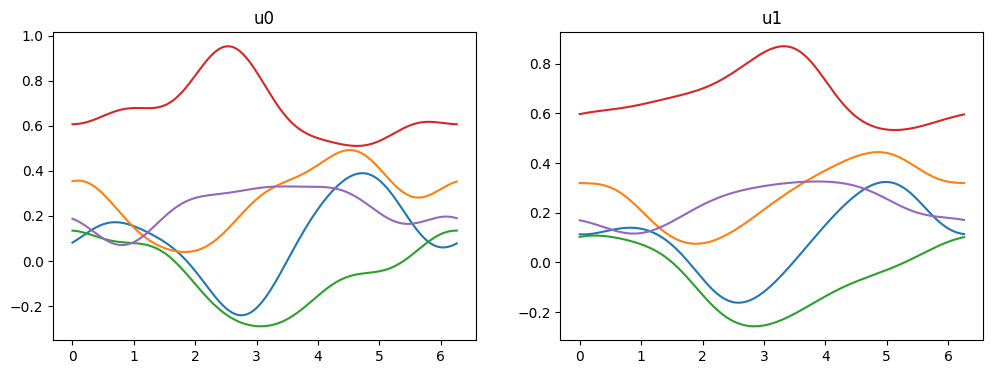

In [3]:
n_samples = 15000
x_bounds = (0, 2*np.pi)
space_resolution = 256

n_coeffs = 5
coeff_mean = 0
coeff_scale = 5
random_state = 42

visc = 0.1
t_bounds = (0, 1)

u0 = generate_initial(n_samples, space_resolution, n_coeffs, coeff_mean, coeff_scale, random_state)
u1 = solve_burgers(u0, visc, x_bounds, t_bounds)

print(f"{u0.shape=}, {u1.shape=}")
plot_pair((u0, u1), x_bounds, space_resolution)

Save data

In [4]:
np.save("u0.npy", u0)
np.save("u1.npy", u1)

Load data

In [5]:
del u0, u1

u0 = np.load("u0.npy")
u1 = np.load("u1.npy")

Look at Fourier

/tmp/ipykernel_16136/2786310677.py:6: RuntimeWarning: divide by zero encountered in log
  fft_u0_to_plot = np.log(np.abs(fft_u0)[:, k_bounds[0]:k_bounds[1]])


fft_u0.shape=(15000, 129), fft_u1.shape=(15000, 129)


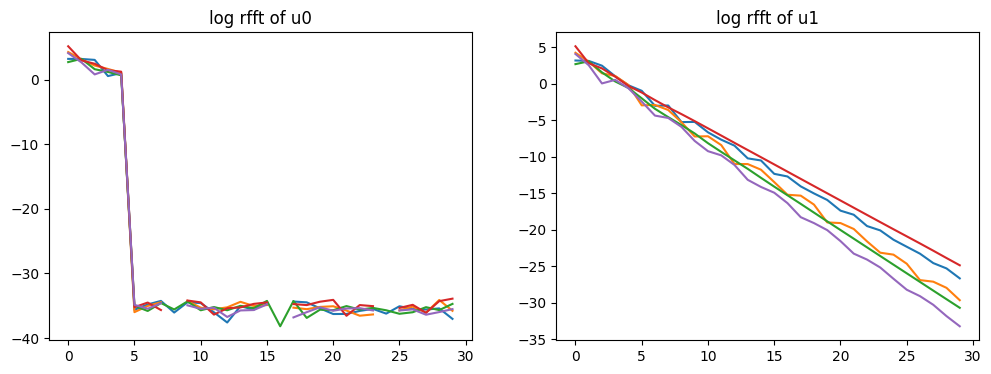

In [6]:
fft_u0 = np.fft.rfft(u0)
fft_u1 = np.fft.rfft(u1)

k_bounds = (0, 30)
k_resolution = k_bounds[1] - k_bounds[0]
fft_u0_to_plot = np.log(np.abs(fft_u0)[:, k_bounds[0]:k_bounds[1]])
fft_u1_to_plot = np.log(np.abs(fft_u1)[:, k_bounds[0]:k_bounds[1]])

print(f"{fft_u0.shape=}, {fft_u1.shape=}")
plot_pair((fft_u0_to_plot, fft_u1_to_plot), k_bounds, k_resolution, prefix = "log rfft of ")
